# Adaptive Filtering Demo

This notebook demonstrates adaptive interferer removal using:

- Wiener (batch) filter (closed-form)
- Steepest descent (deterministic iterative)
- LMS (stochastic gradient, online)

The notebook uses a synthetic example where a desired signal (speech-like) is corrupted by an interference that is correlated with a reference signal. All plots are generated with matplotlib.

In [1]:
import os

REPO_URL = "https://github.com/fabioantonacci79/BasicDSP.git"
REPO_NAME = "BasicDSP"

if not os.path.exists(REPO_NAME):
    !git clone {REPO_URL}

%cd BasicDSP/notebooks

# Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, linalg
from IPython.display import Audio, display
plt.rcParams['figure.dpi'] = 120


## 1. Generate synthetic signals

We create a clean 'desired' signal `s(n)` (sum of low-frequency sinusoids), a reference signal `x(n)` (colored noise), and an interference `v(n)` produced by filtering `x(n)` with an unknown FIR `h_true`. The primary signal is `d(n)=s(n)+v(n)+` small measurement noise.

In [2]:
# Synthetic signals parameters
np.random.seed(1)
N = 16000  # number of samples
t = np.arange(N)
fs = 8000  # sampling freq (Hz) for display purposes only

# desired signal: speech-like (sum of sinusoids)
s = 0.8*np.sin(2*np.pi*200*t/fs) + 0.3*np.sin(2*np.pi*440*t/fs*0.7)

# reference: white noise passed through a small FIR to make it colored
b_ref = np.array([0.9, -0.5, 0.25])
x_full = np.random.randn(N+50)
x = signal.lfilter(b_ref, [1.0], x_full)[:N]

# interference path (unknown) from x to v inside d
M = 32  # adaptive filter length we'll use
h_true = np.zeros(M)
h_true[:len(b_ref)] = [0.9, -0.5, 0.25]  # make the true path similar to b_ref
v = signal.lfilter(h_true, [1.0], x_full)[:N]

# primary input
d = s + v + 0.01*np.random.randn(N)

print('Signals generated: N=%d, filter length M=%d' % (N, M))


Signals generated: N=16000, filter length M=32


You can listen to a short segment of `d(n)` (primary) and `s(n)` (clean) to hear the interference effect.

In [3]:
# Play a short segment (~1 second)
seg = slice(1000, 1000+fs//2)  # half-second segment
print('Primary (d) first):'); display(Audio(d[seg], rate=fs))
print('Clean desired (s) next):'); display(Audio(s[seg], rate=fs))


Primary (d) first):


Clean desired (s) next):


## 2. Wiener (batch) solution

Compute the Wiener filter (MMSE) using empirical estimates of R_xx and r_xd over the dataset.

In [4]:
# Build data matrix for reference x to compute R and r
X = np.zeros((N, M))
for n in range(N):
    for k in range(M):
        idx = n-k
        X[n,k] = x[idx] if idx >= 0 else 0.0

Rxx = (X.T @ X) / N
rxd = (X.T @ d) / N
# Wiener solution (regularize slightly for stability)
reg = 1e-6*np.eye(M)
w_wiener = linalg.solve(Rxx + reg, rxd)
print('Computed Wiener filter (first 8 taps):', np.round(w_wiener[:8],3))

# Apply Wiener filter to produce estimate
y_wiener = X @ w_wiener
e_wiener = d - y_wiener


Computed Wiener filter (first 8 taps): [1.002e+00 2.000e-03 2.000e-03 1.000e-03 0.000e+00 0.000e+00 0.000e+00
 0.000e+00]


## 3. Steepest Descent (deterministic iterative)

We perform iterative steepest descent using the exact Rxx and rxd (so it converges to the Wiener solution).

In [5]:
# Steepest descent parameters
mu_sd = 0.5 / (np.max(np.linalg.eigvals(Rxx).real) + 1e-12)  # heuristic
n_iters = 200
w_sd = np.zeros(M)
w_hist_sd = np.zeros((n_iters, M))
for k in range(n_iters):
    grad = -2*rxd + 2*(Rxx @ w_sd)
    w_sd = w_sd - mu_sd*grad
    w_hist_sd[k,:] = w_sd

print('Steepest descent final (first 8 taps):', np.round(w_sd[:8],3))


Steepest descent final (first 8 taps): [1.002e+00 2.000e-03 2.000e-03 1.000e-03 0.000e+00 0.000e+00 0.000e+00
 0.000e+00]


## 4. LMS (stochastic gradient)

Online adaptation: the LMS update uses instantaneous error `e(n)` and reference vector `x(n)`.

In [6]:
# LMS parameters
mu = 0.001  # step size (tune as needed)
w_lms = np.zeros(M)
w_hist = np.zeros((N, M))
mse_inst = np.zeros(N)

for n in range(N):
    xvec = X[n,:]
    y = w_lms @ xvec
    e = d[n] - y
    w_lms = w_lms + mu * e * xvec
    w_hist[n,:] = w_lms
    mse_inst[n] = e**2

print('LMS final (first 8 taps):', np.round(w_lms[:8],3))


LMS final (first 8 taps): [0.997 0.002 0.005 0.006 0.008 0.01  0.011 0.011]


## 5. Results and plots

Compare the true path `h_true`, Wiener solution, steepest descent final, and LMS final taps.

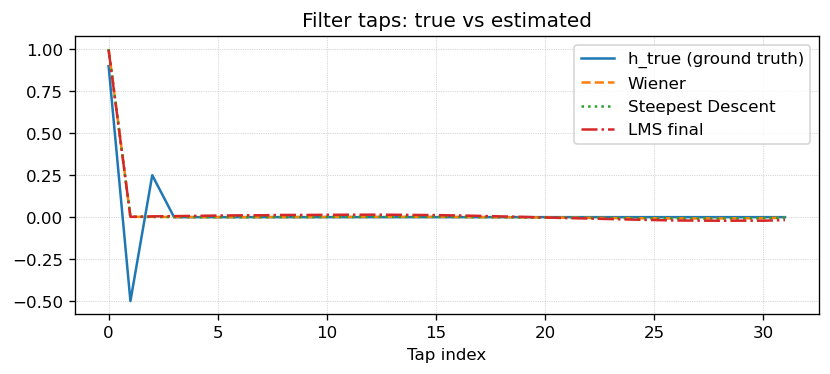

In [34]:
plt.figure(figsize=(8,3))
plt.plot(h_true, label='h_true (ground truth)')
plt.plot(w_wiener, '--', label='Wiener')
plt.plot(w_sd, ':', label='Steepest Descent')
plt.plot(w_lms, '-.', label='LMS final')
plt.legend()
plt.title('Filter taps: true vs estimated')
plt.xlabel('Tap index')
plt.grid(True, linestyle=':', linewidth=0.4)
plt.show()


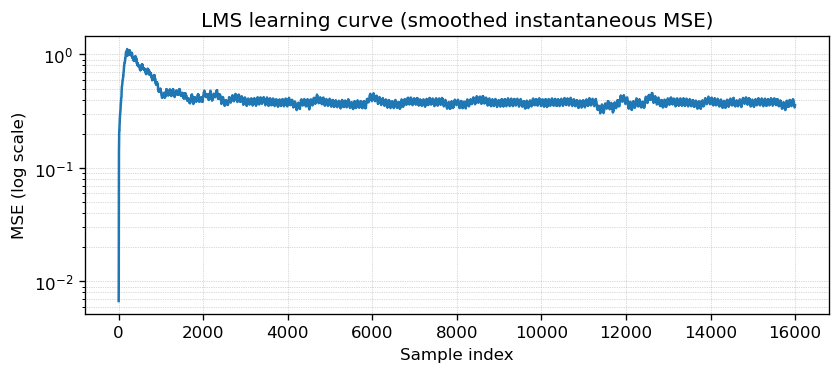

In [12]:
plt.figure(figsize=(8,3))
# smooth MSE for display
from scipy.signal import lfilter
mse_smooth = lfilter(np.ones(200)/200, [1], mse_inst[1 :])
plt.semilogy(mse_smooth + 1e-12)
plt.title('LMS learning curve (smoothed instantaneous MSE)')
plt.xlabel('Sample index')
plt.ylabel('MSE (log scale)')
plt.grid(True, which='both', linestyle=':', linewidth=0.4)
plt.show()


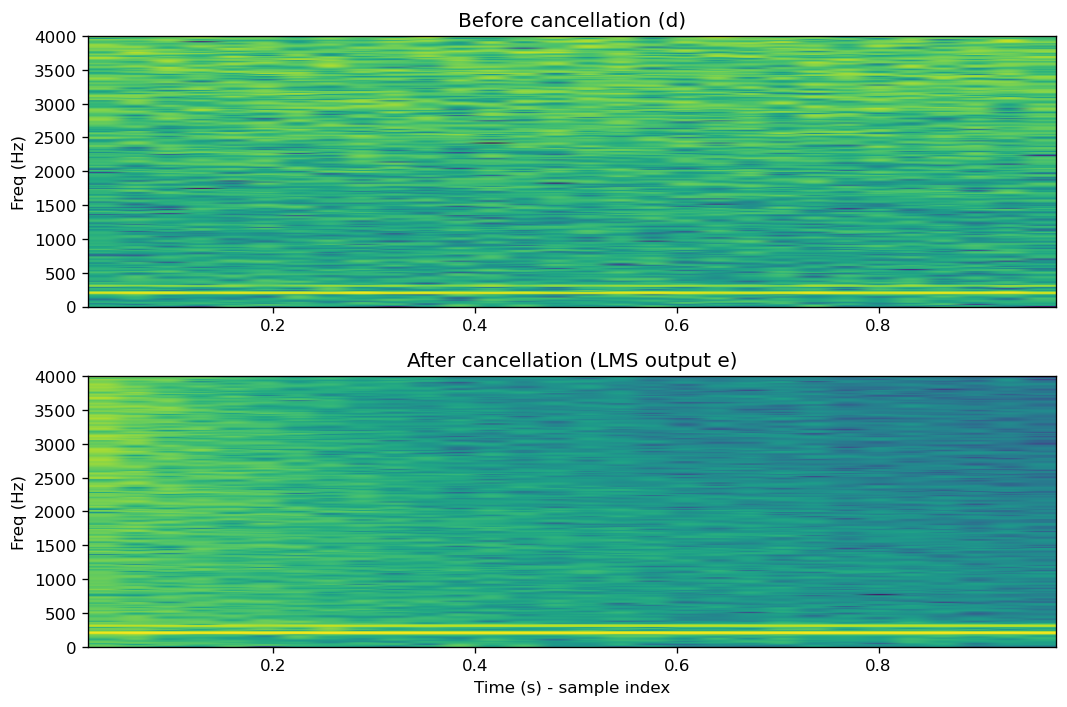

In [10]:
# apply learned LMS filter (final) to reference and compute enhanced output
y_est = np.zeros(N)
for n in range(N):
    xvec = X[n,:]
    y_est[n] = w_hist[n,:] @ xvec
e_out = d - y_est

plt.figure(figsize=(9,6))
plt.subplot(2,1,1)
plt.specgram(d, NFFT=512, Fs=fs, noverlap=256)
plt.title('Before cancellation (d)')
plt.ylabel('Freq (Hz)')
plt.subplot(2,1,2)
plt.specgram(e_out, NFFT=512, Fs=fs, noverlap=256)
plt.title('After cancellation (LMS output e)')
plt.ylabel('Freq (Hz)')
plt.xlabel('Time (s) - sample index')
plt.tight_layout()
plt.show()


You can listen to a short segment before and after cancellation:

In [28]:
seg = slice(1000, 1000+fs//2)
print('Before (d):'); display(Audio(d[seg], rate=fs))
print('After (e_out):'); display(Audio(e_out[seg], rate=fs))


Before (d):


After (e_out):


In [12]:
# Save results
import numpy as _np
_np.savez('adaptive_demo_results.npz', w_wiener=w_wiener, w_sd=w_sd, w_lms=w_lms, h_true=h_true)
print('Saved adaptive_demo_results.npz in the notebook working directory.')


Saved adaptive_demo_results.npz in the notebook working directory.


----

**Notes / next steps:**

- You can tune `mu` for LMS and `M` (filter length) to see different behaviors.
- Replace the synthetic `s(n)` with a real speech recording (upload a WAV) to try the demo on real audio.
- Consider adding NLMS (normalized LMS) for robustness to input power changes.